# Case - Modelo preditivo para aprovação de crédito

Modelos de score de crédito calculam a probabilidade de inadimplência e são uma das principais ferramentas utilizadas por diversas empresas para aprovar ou negar um crédito.

O objetivo deste desafio é criar um modelo preditivo calculando a probabilidade de inadimplência de cada novo pedido de crédito.

## Objetivo

### Construir qualquer modelo preditivo utilizando o arquivo treino.csv.

Utilize este modelo para gerar as previsões na base teste.csv, inserindo uma nova coluna na tabela de dados do arquivo teste.csv que contenha as previsões e nomeie esta colunacom o nome "inadimplente". Espera-se que não seja necessário mais que um dia para a resolução deste problema.

In [1]:
#!pip install xgboost -q
#!pip install -q imblearn

In [2]:
# Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import imblearn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Carregando os Dados

In [3]:
# Carregar os dados
df_treino = pd.read_csv("treino.csv")
df_teste = pd.read_csv("teste.csv")

In [4]:
# Shape
df_treino.shape

(110000, 11)

In [5]:
# Shape
df_teste.shape

(40000, 10)

## Análise Exploratória dos Dados

In [6]:
# Visualizar uma amostra do dados de treino
df_treino.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
# Visualizar amostra dos dados de teste
df_teste.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [8]:
df_treino.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,8.823700e+04,110000.000000,110000.000000,110000.000000,110000.000000,107122.000000
mean,0.066645,5.929979,52.255636,0.424055,354.823589,6.637411e+03,8.445573,0.269955,1.019891,0.243891,0.757482
std,0.249408,252.301965,14.768241,4.240780,2074.140421,1.338395e+04,5.139026,4.217326,1.135989,4.204137,1.114670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030054,41.000000,0.000000,0.175016,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.155936,52.000000,0.000000,0.366682,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.562806,63.000000,0.000000,0.866874,8.225000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [9]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           110000 non-null  int64  
 1   util_linhas_inseguras                  110000 non-null  float64
 2   idade                                  110000 non-null  int64  
 3   vezes_passou_de_30_59_dias             110000 non-null  int64  
 4   razao_debito                           110000 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             110000 non-null  int64  
 7   numero_vezes_passou_90_dias            110000 non-null  int64  
 8   numero_emprestimos_imobiliarios        110000 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  110000 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

In [10]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  40000 non-null  float64
 1   idade                                  40000 non-null  int64  
 2   vezes_passou_de_30_59_dias             40000 non-null  int64  
 3   razao_debito                           40000 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             40000 non-null  int64  
 6   numero_vezes_passou_90_dias            40000 non-null  int64  
 7   numero_emprestimos_imobiliarios        40000 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  40000 non-null  int64  
 9   numero_de_dependentes                  38954 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 3.1 MB


## Limpeza e Conversão do Dados

In [11]:
# Contando os valores nulos dos dados de treino
df_treino.isnull().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [12]:
# Contando os valores nulos dos dados de teste
df_teste.isnull().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7968
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1046
dtype: int64

In [13]:
# Verificando o percentual de valores nulos
total = df_treino.isnull().sum()
percentual = (df_treino.isnull().sum() / df_treino.isnull().count() * 100)
pd.concat([total, percentual], axis=1, keys=['Total', 'Percentual'])

,Total,Percentual
inadimplente,0,0.000000
util_linhas_inseguras,0,0.000000
idade,0,0.000000
vezes_passou_de_30_59_dias,0,0.000000
razao_debito,0,0.000000
salario_mensal,21763,19.784545
numero_linhas_crdto_aberto,0,0.000000
numero_vezes_passou_90_dias,0,0.000000
numero_emprestimos_imobiliarios,0,0.000000
numero_de_vezes_que_passou_60_89_dias,0,0.000000


Apesar de aproximadamente 20% dos dados estarem com valores nulos, resolvi retirar estes dados do conjunto de dados para treinar o modelo.

Também, retirei os valores ausentes conjunto de dados de teste, porque após treinando o modelo não aceita receber estes dados nulos.

In [14]:
# Removendo dados faltantes
df_treino_limpo = df_treino.dropna()
df_testelimpo = df_teste.dropna()

In [15]:
df_treino_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88237 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   inadimplente                           88237 non-null  int64  
 1   util_linhas_inseguras                  88237 non-null  float64
 2   idade                                  88237 non-null  int64  
 3   vezes_passou_de_30_59_dias             88237 non-null  int64  
 4   razao_debito                           88237 non-null  float64
 5   salario_mensal                         88237 non-null  float64
 6   numero_linhas_crdto_aberto             88237 non-null  int64  
 7   numero_vezes_passou_90_dias            88237 non-null  int64  
 8   numero_emprestimos_imobiliarios        88237 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  88237 non-null  int64  
 10  numero_de_dependentes                  88237 non-null  float64
dtypes

In [16]:
df_testelimpo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32032 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  32032 non-null  float64
 1   idade                                  32032 non-null  int64  
 2   vezes_passou_de_30_59_dias             32032 non-null  int64  
 3   razao_debito                           32032 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             32032 non-null  int64  
 6   numero_vezes_passou_90_dias            32032 non-null  int64  
 7   numero_emprestimos_imobiliarios        32032 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  32032 non-null  int64  
 9   numero_de_dependentes                  32032 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.7 MB


É feito uma conversão na variável alvo(inadimplentes) de tipo inteiro para tipo string, assim os dados passam a ser categóricos, porque queremos saber se o cliente ao pedir crédito será inadimplente(1) ou não(0).

In [17]:
# Conversão da coluna inadimplente de inteiro para categórica
df_treino_limpo['inadimplente'] = df_treino_limpo['inadimplente'].astype(str)
df_treino_limpo['inadimplente'].value_counts()

0    82153
1     6084
Name: inadimplente, dtype: int64

In [18]:
# Separação da variável alvo
X_treino = df_treino_limpo.iloc[:,1:]
y_treino = df_treino_limpo.iloc[:,0].values

In [19]:
X_treino.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [20]:
y_treino

array(['1', '0', '0', ..., '0', '0', '0'], dtype=object)

## Balanceamento das classes

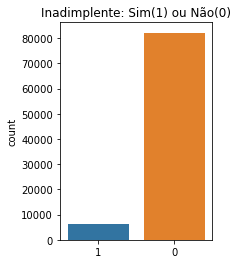

In [21]:
# Verificar se as classes estão balanceadas
plt.subplot(1,2,2)
plt.title("Inadimplente: Sim(1) ou Não(0)")
sns.countplot(y_treino);

Foi ralizado uma contagem das classes e constatou-se que estas estão muito desbalanceadas. Utilizamos a função `SMOTE` do pacote imblearn para fazer este balanceamento criando dados sintéticos.

Dados desbalanceados tendem a tornar o modelo de machine learning enviesado, tendendo mais para uma classe do que outra, no nosso caso, os modelos aprenderiam mais sobre clientes adimplentes do que inadimplentes.

In [22]:
# Cria o balanceador SMOTE
smote_bal = SMOTE()

# Aplica o balanceador
X_treino_res, y_treino_res = smote_bal.fit_resample(X_treino, y_treino)

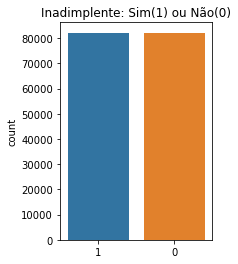

In [23]:
plt.subplot(1,2,2)
plt.title("Inadimplente: Sim(1) ou Não(0)")
sns.countplot(y_treino_res);

## Padronização dos dados

Após o balanceamento, fazemos uma padronização nos dados para melhorar a performance dos modelos de aprendizado de máquina.

In [24]:
scaler = MinMaxScaler()
X_treino_scaled = scaler.fit_transform(X_treino_res)
X_teste_scaled = scaler.transform(df_testelimpo)

## Treinamento do Modelo

### Regressão Logística

Para inciar o treinamento do modelo, vamos começar com o algoritmo de Regressão Logística.

In [25]:
# Cria o modelo
modelo = LogisticRegression(max_iter=1000)

In [26]:
# Separando os dados em folds
num_folds = 5
kfold = KFold(num_folds, shuffle=True)

In [27]:
# Treina o modelo e verifica o score
start = time.time()
modelo_v1 = modelo.fit(X_treino_scaled, y_treino_res)
scores_v1 = cross_val_score(modelo_v1, X_treino_scaled, y_treino_res, cv = kfold, scoring = 'accuracy')
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 8.038665771484375


In [28]:
# Imprimindo o resultado do score
print ("ExtraTreesClassifier -> Acurácia em Treino: Média = %0.3f%% Desvio Padrão = %0.3f%%" % (np.mean(scores_v1)*100, np.std(scores_v1)*100))

ExtraTreesClassifier -> Acurácia em Treino: Média = 65.359% Desvio Padrão = 0.218%


In [29]:
previsoes_v1 = modelo_v1.predict(X_teste_scaled)
previsoes_v1

array(['0', '0', '0', ..., '0', '0', '1'], dtype=object)

### Suporte Vector Machine

In [30]:
# Importando a biblioteca
from sklearn import svm

In [31]:
# Cria o modelo
modelo = svm.SVC()

In [32]:
# Treina o modelo e verifica o score
start = time.time()
modelo_v2 = modelo.fit(X_treino_scaled, y_treino_res)
scores_v2 = cross_val_score(modelo_v2, X_treino_scaled, y_treino_res, cv = kfold, scoring = 'accuracy')
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 6232.161695957184


In [33]:
# Imprimindo o resultado do score
print ("ExtraTreesClassifier -> Acurácia em Treino: Média = %0.3f%% Desvio Padrão = %0.3f%%" % (np.mean(scores_v2)*100, np.std(scores_v2)*100))

ExtraTreesClassifier -> Acurácia em Treino: Média = 70.206% Desvio Padrão = 0.257%


In [34]:
previsoes_v2 = modelo_v2.predict(X_teste_scaled)
previsoes_v2

array(['0', '0', '0', ..., '0', '1', '1'], dtype=object)

### Random Forest

In [35]:
# Importando a biblioteca
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Cria o modelo
modelo = RandomForestClassifier()

In [37]:
# Treina o modelo e verifica o score
start = time.time()
modelo_v3 = modelo.fit(X_treino_scaled, y_treino_res)
scores_v3 = cross_val_score(modelo_v3, X_treino_scaled, y_treino_res, cv = kfold, scoring = 'accuracy')
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 159.83491683006287


In [38]:
# Imprimindo o resultado do score
print ("ExtraTreesClassifier -> Acurácia em Treino: Média = %0.3f%% Desvio Padrão = %0.3f%%" % (np.mean(scores_v3)*100, np.std(scores_v3)*100))

ExtraTreesClassifier -> Acurácia em Treino: Média = 92.264% Desvio Padrão = 0.095%


In [39]:
previsoes_v3 = modelo_v3.predict(X_teste_scaled)
previsoes_v3

array(['0', '0', '0', ..., '0', '0', '1'], dtype=object)

### XGBoost

In [40]:
# Importando a biblioteca
from xgboost import XGBClassifier

In [41]:
# Criando o modelo
modelo = XGBClassifier()
y_treino_res = y_treino_res.astype(int)

In [42]:
# Treinando o modelo e verificando o score
start = time.time()
modelo_v4 = modelo.fit(X_treino_scaled, y_treino_res)
scores_v4 = cross_val_score(modelo_v4, X_treino_scaled, y_treino_res, cv = kfold, scoring = 'accuracy')
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 73.06109547615051


In [43]:
# Imprimindo o resultado do score
print ("ExtraTreesClassifier -> Acurácia em Treino: Média = %0.3f%% Desvio Padrão = %0.3f%%" % (np.mean(scores_v4)*100, np.std(scores_v4)*100))

ExtraTreesClassifier -> Acurácia em Treino: Média = 88.728% Desvio Padrão = 0.232%


In [44]:
previsoes_v4 = modelo_v4.predict(X_teste_scaled)
previsoes_v4

array([0, 1, 0, ..., 0, 0, 1])

## Considerações finais

Foi feito previsões usando quatro tipos de algoritmos de aprendizado de máquina: Regressão Logística, SVM - Support Vector Machine, Random Forest e XGBoot.

A métrica utilizada para medir a performance de cada algoritmo foi a acurácia sendo que cada um teve como resultado:

Algoritmo|Acurácia(%)
--------------|----------
Regressão Logística| 65,359
SVM                | 70,206
Random Forest      | 92,264
XGBoost            | 88,728

Sendo o Random Forest o que apresentou melhor performance, então foi utilizado as previsões deste algoritmo para montar o novo arquivo de **teste.csv** com a coluna inadimplentes.

## Salvando o arquivo

In [50]:
df_teste_novo = df_testelimpo

In [51]:
df_teste_novo.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [53]:
df_teste_novo['inadimplentes'] = previsoes_v3
df_teste_novo.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


In [54]:
df_teste_novo.to_csv('teste_novo.csv')